In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

### Globals

In [49]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['dp1', 'dp2', 'greedy']
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

### Helpers

In [80]:
def get_features(id_):
    return np.array(open(FEATURES_PATH + str(id_),'r').read().split(), dtype=float)

### Reading outputs

In [51]:
alg_data = defaultdict(list)

for alg in ALGORITHMS:
    file = open(OUTPUT_PATH + alg,'r')
    alg_data[alg] = defaultdict(list)
    for row in file:
        try: # para cuando hay
            id_, fo, time = row.split()
            alg_data[alg][int(id_)].append([(int)(fo), (float)(time)])
        except:
            pass

In [52]:
correct_ids = set()
dp1_ids = alg_data['dp1'].keys()
dp2_ids = alg_data['dp2'].keys()
greedy_ids = alg_data['greedy'].keys()
size = 19200
for id_ in range(size):
    if ((id_ in dp1_ids) and (id_ in dp2_ids) and (id_ in greedy_ids)):
        correct_ids.add(id_)

In [109]:
ALGORITHMS.index('greedy')

2

In [110]:
train_ = []
label_ = [-1] * len(correct_ids)*10
count = 0
for inst in correct_ids:
    fts = get_features(inst)
    for t in range(10):
        train_.append([inst, *fts, t+1])
        best_fo = 0
        for alg in ALGORITHMS:
            try:
                local_best = max([i for i in alg_data[alg][inst] if i[1] <= t+1])[0] # lista de valores menores al tiempo
                if local_best > best_fo:
                    best_fo = local_best
                    label_[count] = ALGORITHMS.index(alg)
            except:
                pass
        count += 1
                

In [111]:
data = pd.DataFrame(data=train_, columns=['id', *FEATURES, 't'])

In [112]:
label_

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [86]:
data

,id,num_elem,cap,cap_mean_w,cap_median_w,cap_desv_w,mean_w_mean_v,median_w_median_v,desv_w_desv_v,max_w_min_w,...,desv_w,min_w,max_w,mean_v,median_v,desv_v,min_v,max_v,p_coef,t
0,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,1
1,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,2
2,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,3
3,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,4
4,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,5
5,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,6
6,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,7
7,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,8
8,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,9
9,0,92.0,12.0,1.916667,1.714286,4.039866,0.126788,0.145833,0.097213,10.0,...,2.970396,1.0,11.0,49.380435,48.0,30.555666,1.0,99.0,0.052918,10


## NN

In [90]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import matplotlib.pyplot as plt

/home/isaias/miniconda2/envs/musegan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [92]:
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [93]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [113]:
model.fit(np.array(train_), np.array(label_), epochs=3)

Epoch 1/3
62220/62220 [==============================] - 3s 50us/step - loss: 6.9709 - acc: 0.5675
Epoch 2/3
62220/62220 [==============================] - 2s 35us/step - loss: 6.8778 - acc: 0.5733
Epoch 3/3
62220/62220 [==============================] - 2s 36us/step - loss: 6.8778 - acc: 0.5733


In [120]:
sample.shape

(23,)

In [121]:
sample = np.array(train_[0])
sample = (np.expand_dims(sample,0))
predictions_single = model.predict(sample)

print(predictions_single)

[[1.0000000e+00 3.7367149e-30 4.8656455e-37 3.7832067e-34 1.1051801e-33
  0.0000000e+00 0.0000000e+00 1.2747654e-25 1.0199556e-32 2.2265786e-27]]


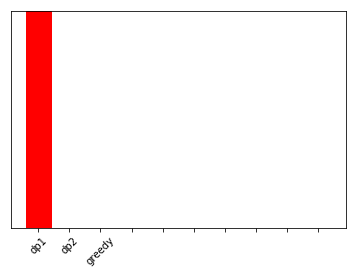

In [124]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), ALGORITHMS, rotation=45)

In [123]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')